# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
%%sh
pip install -q --upgrade pip
pip install -q sagemaker smdebug smdebug-rulesconfig==0.1.2  awscli --upgrade

In [2]:
!pip install ipywidgets
#!pip list

  Using cached jedi-0.17.2-py2.py3-none-any.whl (1.4 MB)
  Using cached parso-0.7.1-py2.py3-none-any.whl (109 kB)
  Attempting uninstall: parso
    Found existing installation: parso 0.8.0
    Uninstalling parso-0.8.0:
      Successfully uninstalled parso-0.8.0
  Attempting uninstall: jedi
    Found existing installation: jedi 0.18.0
    Uninstalling jedi-0.18.0:
      Successfully uninstalled jedi-0.18.0


In [3]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [7]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
import pip
import sys

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        !{sys.executable} -m pip install {package}
        
required_packages=['smdebug', 'pytest']

for package in required_packages:
    import_or_install(package)

  Using cached pytest-7.0.1-py3-none-any.whl (296 kB)
  Using cached py-1.11.0-py2.py3-none-any.whl (98 kB)
  Using cached iniconfig-1.1.1-py2.py3-none-any.whl (5.0 kB)
  Using cached tomli-1.2.3-py3-none-any.whl (12 kB)
  Using cached pluggy-1.0.0-py2.py3-none-any.whl (13 kB)


In [8]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import time
#print(time.time())
import sagemaker

print(f"sagemaker-version {sagemaker.__version__}")
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()
prefix = "computervision-training-dataset"
smclient = boto3.Session().client("sagemaker")
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

sagemaker-version 2.72.0
arn:aws:iam::124974773620:role/service-role/AmazonSageMaker-ExecutionRole-20230228T160414
Region us-east-1
Default s3 bucket : sagemaker-us-east-1-124974773620


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [9]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-03-08 12:52:42--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.160
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  48.4MB/s    in 25s     

2023-03-08 12:53:16 (43.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [86]:
%%sh
ls -l dogImages

total 36
drwxr-xr-x 135 root root 14336 Mar 27  2017 test
drwxr-xr-x 135 root root 14336 Mar 27  2017 train
drwxr-xr-x 135 root root 14336 Mar 27  2017 valid


In [11]:
# uploading the data to s3
inputs = sess.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(inputs)

s3://sagemaker-us-east-1-124974773620/computervision-training-dataset


In [9]:
s3_train_data = "s3://sagemaker-us-east-1-124974773620/computervision-training-dataset/train/"
s3_validation_data = "s3://sagemaker-us-east-1-124974773620/computervision-training-dataset/valid/"
s3_test_data = "s3://sagemaker-us-east-1-124974773620/computervision-training-dataset/test/"

s3_output_key = "image-classification-dogimages-full-training/output"
s3_output_location = "s3://{}/{}/".format(bucket, s3_output_key)

s3_input_train = sagemaker.TrainingInput(
    s3_data=s3_train_data, 
    content_type="application/x-recordio",
    s3_data_type= "S3Prefix"
)
s3_input_validation = sagemaker.TrainingInput(
    s3_data=s3_validation_data, 
    content_type="application/x-recordio",
    s3_data_type= "S3Prefix"
)

In [10]:
!pygmentize hpo.py

#TODO: Import your dependencies.
#For instance, below are some dependencies you might need if you are using Pytorch
from __future__ import print_function
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR


import argparse
import logging
import os
import sys
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# logging configs
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))





def test(model, test_loader, criterion, device, epoch_no):
    '''
    TODO: Complete this function that can take a model and a 
          testing data loader and will get the test accuray/loss of the model
          Remember to include any debugging/profiling hooks that you might need
    '''
    #model.to('cp

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [12]:
#TODO: Declare your HP ranges, metrics etc.
from time import gmtime, strftime
from sagemaker.tuner import (CategoricalParameter,
                             ContinuousParameter,
                             HyperparameterTuner)

In [98]:
tuning_job_name = "imageclassif-job-{}".format(strftime("%d-%H-%M-%S", gmtime()))

In [99]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [ ]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = tuning_job_name,
    role = role,
    instance_count = 1,
    instance_type = "ml.m5.xlarge", 
    py_version = "py36",
    framework_version = "1.8",
    output_path= s3_output_location,
) # TODO: Your estimator here

In [ ]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
) # TODO: Your HP tuner here

In [101]:
tuning_job_name

'imageclassif-job-09-14-02-00'

In [102]:
# TODO: Fit your HP Tuner
tuner.fit(
    {"training": "s3://sagemaker-us-east-1-124974773620/computervision-training-dataset"},
    job_name=tuning_job_name,
    include_cls_metadata=False,
)
tuner.wait()
# TODO: Remember to include your data channels

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: imageclassif-job-09-14-02-00


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [103]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-09 14:40:23 Starting - Preparing the instances for training
2023-03-09 14:40:23 Downloading - Downloading input data
2023-03-09 14:40:23 Training - Training image download completed. Training in progress.
2023-03-09 14:40:23 Uploading - Uploading generated training model
2023-03-09 14:40:23 Completed - Resource reused by training job: imageclassif-job-09-14-02-00-004-e120c854


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'eps': '7.087019605916528e-09',
 'lr': '0.0003016934041729402',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"imageclassif-job-09-14-02-00"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-124974773620/imageclassif-job-09-14-02-00/source/sourcedir.tar.gz"',
 'weight_decay': '0.006966716427920531'}

In [104]:
tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
tuner_metrics.dataframe().sort_values(["FinalObjectiveValue"], ascending=False).head(5)

,batch_size,eps,lr,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
3,"""128""",4.413816e-09,0.089325,0.007360,imageclassif-job-09-14-02-00-007-7e8ba43c,Stopped,4.8903,2023-03-09 15:01:18+00:00,2023-03-09 15:20:21+00:00,1143.0
4,"""64""",1.088848e-09,0.004160,0.011223,imageclassif-job-09-14-02-00-006-7e139054,Stopped,4.8903,2023-03-09 15:02:24+00:00,2023-03-09 15:20:56+00:00,1112.0
5,"""128""",3.144040e-09,0.008193,0.032153,imageclassif-job-09-14-02-00-005-3d29af58,Stopped,4.8903,2023-03-09 14:41:37+00:00,2023-03-09 15:01:02+00:00,1165.0
6,"""64""",9.633600e-09,0.020110,0.034857,imageclassif-job-09-14-02-00-004-e120c854,Stopped,4.8903,2023-03-09 14:40:25+00:00,2023-03-09 14:57:56+00:00,1051.0
0,"""64""",2.956729e-09,0.000768,0.090580,imageclassif-job-09-14-02-00-010-dd4ac558,Stopped,4.8891,2023-03-09 15:57:28+00:00,2023-03-09 16:14:46+00:00,1038.0


In [106]:
df = tuner_metrics.dataframe()
total_time = df["TrainingElapsedTimeSeconds"].sum() / 3600
print("The total training time is {:.2f} hours".format(total_time))
df["TrainingJobStatus"].value_counts()

The total training time is 3.89 hours


Stopped      7
Completed    3
Name: TrainingJobStatus, dtype: int64

In [107]:
df[df.TrainingJobStatus == "Stopped"]

,batch_size,eps,lr,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""64""",2.956729e-09,0.000768,0.090580,imageclassif-job-09-14-02-00-010-dd4ac558,Stopped,4.8891,2023-03-09 15:57:28+00:00,2023-03-09 16:14:46+00:00,1038.0
3,"""128""",4.413816e-09,0.089325,0.007360,imageclassif-job-09-14-02-00-007-7e8ba43c,Stopped,4.8903,2023-03-09 15:01:18+00:00,2023-03-09 15:20:21+00:00,1143.0
4,"""64""",1.088848e-09,0.004160,0.011223,imageclassif-job-09-14-02-00-006-7e139054,Stopped,4.8903,2023-03-09 15:02:24+00:00,2023-03-09 15:20:56+00:00,1112.0
5,"""128""",3.144040e-09,0.008193,0.032153,imageclassif-job-09-14-02-00-005-3d29af58,Stopped,4.8903,2023-03-09 14:41:37+00:00,2023-03-09 15:01:02+00:00,1165.0
6,"""64""",9.633600e-09,0.020110,0.034857,imageclassif-job-09-14-02-00-004-e120c854,Stopped,4.8903,2023-03-09 14:40:25+00:00,2023-03-09 14:57:56+00:00,1051.0
7,"""64""",5.383914e-09,0.000276,0.002126,imageclassif-job-09-14-02-00-003-f70f4f16,Stopped,4.8876,2023-03-09 14:23:04+00:00,2023-03-09 14:40:17+00:00,1033.0
8,"""128""",8.259162e-09,0.000137,0.025177,imageclassif-job-09-14-02-00-002-f32a5fdb,Stopped,4.8836,2023-03-09 14:03:20+00:00,2023-03-09 14:22:52+00:00,1172.0


In [108]:
df[df.TrainingJobStatus == "Completed"]

,batch_size,eps,lr,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""128""",8.735985e-09,0.000180,0.061638,imageclassif-job-09-14-02-00-009-311d6757,Completed,4.8765,2023-03-09 15:22:08+00:00,2023-03-09 15:57:00+00:00,2092.0
2,"""128""",3.494814e-09,0.000345,0.006155,imageclassif-job-09-14-02-00-008-88f2d098,Completed,4.8797,2023-03-09 15:22:12+00:00,2023-03-09 15:56:43+00:00,2071.0
9,"""128""",7.087020e-09,0.000302,0.006967,imageclassif-job-09-14-02-00-001-4cb811ff,Completed,4.8714,2023-03-09 14:03:16+00:00,2023-03-09 14:38:40+00:00,2124.0


In [109]:
tuning_job_name = tuner._current_job_name

tuner_parent_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
if not tuner_parent_metrics.dataframe().empty:
    df_parent = tuner_parent_metrics.dataframe().sort_values(
        ["FinalObjectiveValue"], ascending=False
    )

df_parent

,batch_size,eps,lr,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
3,"""128""",4.413816e-09,0.089325,0.007360,imageclassif-job-09-14-02-00-007-7e8ba43c,Stopped,4.8903,2023-03-09 15:01:18+00:00,2023-03-09 15:20:21+00:00,1143.0
4,"""64""",1.088848e-09,0.004160,0.011223,imageclassif-job-09-14-02-00-006-7e139054,Stopped,4.8903,2023-03-09 15:02:24+00:00,2023-03-09 15:20:56+00:00,1112.0
5,"""128""",3.144040e-09,0.008193,0.032153,imageclassif-job-09-14-02-00-005-3d29af58,Stopped,4.8903,2023-03-09 14:41:37+00:00,2023-03-09 15:01:02+00:00,1165.0
6,"""64""",9.633600e-09,0.020110,0.034857,imageclassif-job-09-14-02-00-004-e120c854,Stopped,4.8903,2023-03-09 14:40:25+00:00,2023-03-09 14:57:56+00:00,1051.0
0,"""64""",2.956729e-09,0.000768,0.090580,imageclassif-job-09-14-02-00-010-dd4ac558,Stopped,4.8891,2023-03-09 15:57:28+00:00,2023-03-09 16:14:46+00:00,1038.0
7,"""64""",5.383914e-09,0.000276,0.002126,imageclassif-job-09-14-02-00-003-f70f4f16,Stopped,4.8876,2023-03-09 14:23:04+00:00,2023-03-09 14:40:17+00:00,1033.0
8,"""128""",8.259162e-09,0.000137,0.025177,imageclassif-job-09-14-02-00-002-f32a5fdb,Stopped,4.8836,2023-03-09 14:03:20+00:00,2023-03-09 14:22:52+00:00,1172.0
2,"""128""",3.494814e-09,0.000345,0.006155,imageclassif-job-09-14-02-00-008-88f2d098,Completed,4.8797,2023-03-09 15:22:12+00:00,2023-03-09 15:56:43+00:00,2071.0
1,"""128""",8.735985e-09,0.000180,0.061638,imageclassif-job-09-14-02-00-009-311d6757,Completed,4.8765,2023-03-09 15:22:08+00:00,2023-03-09 15:57:00+00:00,2092.0
9,"""128""",7.087020e-09,0.000302,0.006967,imageclassif-job-09-14-02-00-001-4cb811ff,Completed,4.8714,2023-03-09 14:03:16+00:00,2023-03-09 14:38:40+00:00,2124.0


In [110]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

import pandas as pd

df_parent_objective_value = df_parent[df_parent["FinalObjectiveValue"] > -float("inf")]

p = figure(
    plot_width=900,
    plot_height=400,
    x_axis_type="datetime",
    x_axis_label="datetime",
    y_axis_label=objective_metric_name,
)
p.circle(
    source=df_parent_objective_value, x="TrainingStartTime", y="FinalObjectiveValue", color="black"
)

show(p)

Loading BokehJS ...

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [111]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 128, 'eps': '7.087019605916528e-09', 'lr': '0.0003016934041729402', 'weight_decay': '0.006966716427920531'}


In [17]:
best_hyperparameters = {'batch_size': 128, 'eps': '7.087019605916528e-09', 'lr': '0.0003016934041729402', 'weight_decay': '0.006966716427920531'}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 128, 'eps': '7.087019605916528e-09', 'lr': '0.0003016934041729402', 'weight_decay': '0.006966716427920531'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [26]:
# TODO: Set up debugging and profiling rules and hooks
profiling_and_debugging_job_name = "imageclassif-job-{}".format(strftime("%d-%H-%M-%S", gmtime()))

In [27]:
profiling_and_debugging_job_name

'imageclassif-job-09-19-24-11'

In [28]:
# TODO: Create and fit an estimator
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [29]:
!pygmentize train_model.py

#TODO: Import your dependencies.
#For instance, below are some dependencies you might need if you are using Pytorch
from __future__ import print_function
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR


import argparse
import logging
import os
import sys
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# logging configs
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

#TODO: Import dependencies for Debugging andd Profiling
# ====================================#
# 1. Import SMDebug framework class. #
# ====================================#
import smdebug.pytorch as smd
from smdebug import modes
from smdebug.profiler.utils import str2bool
from smdebug.pytorch import get_hook



d

In [30]:
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    role=role,
    framework_version="1.6", 
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)
estimator.fit({"train": "s3://sagemaker-us-east-1-124974773620/computervision-training-dataset"},wait=True)
# TODO: Your estimator here

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-09-19-25-06-873


2023-03-09 19:25:07 Starting - Starting the training job...
2023-03-09 19:25:26 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-03-09 19:26:26 Downloading - Downloading input data......
2023-03-09 19:27:27 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-09 19:27:32,033 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-09 19:27:32,035 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-09 19:27:32,045 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-09 19:27:32,047 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-09 19:27:32,210 sage

In [31]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [32]:
print(f"Jobname: {job_name}")

Jobname: pytorch-training-2023-03-09-19-25-06-873


In [33]:
import pprint 
for status in description['DebugRuleEvaluationStatuses']:
    status.pop('LastModifiedTime')
    status.pop('RuleEvaluationJobArn')
    pprint.pprint(status)

{'RuleConfigurationName': 'VanishingGradient',
 'RuleEvaluationStatus': 'Error',
 'StatusDetails': 'InternalServerError: We encountered an internal error. '
                  'Please try again.'}
{'RuleConfigurationName': 'Overfit', 'RuleEvaluationStatus': 'NoIssuesFound'}
{'RuleConfigurationName': 'Overtraining',
 'RuleEvaluationStatus': 'NoIssuesFound'}
{'RuleConfigurationName': 'PoorWeightInitialization',
 'RuleEvaluationStatus': 'IssuesFound',
 'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule '
                  'PoorWeightInitialization at step 0 resulted in the '
                  'condition being met\n'}


In [34]:
s3_output_path = description["DebugHookConfig"]["S3OutputPath"] + job_name + '/' + 'debug-output/'

print(s3_output_path)

s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-19-25-06-873/debug-output/


In [35]:
%%sh -s "$s3_output_path"

aws s3 ls --recursive $1

2023-03-09 19:27:38          0 pytorch-training-2023-03-09-19-25-06-873/debug-output/claim.smd
2023-03-09 19:28:48       5955 pytorch-training-2023-03-09-19-25-06-873/debug-output/collections/000000000/worker_0_collections.json
2023-03-09 19:28:12 4921903051 pytorch-training-2023-03-09-19-25-06-873/debug-output/events/000000000000/000000000000_worker_0.tfevents
2023-03-09 19:36:05        100 pytorch-training-2023-03-09-19-25-06-873/debug-output/events/000000000010/000000000010_worker_0.tfevents
2023-03-09 19:39:03        100 pytorch-training-2023-03-09-19-25-06-873/debug-output/events/000000000020/000000000020_worker_0.tfevents
2023-03-09 19:42:02        100 pytorch-training-2023-03-09-19-25-06-873/debug-output/events/000000000030/000000000030_worker_0.tfevents
2023-03-09 19:44:58        100 pytorch-training-2023-03-09-19-25-06-873/debug-output/events/000000000040/000000000040_worker_0.tfevents
2023-03-09 19:47:55        100 pytorch-training-2023-03-09-19-25-06-873/debug-output/events/

In [36]:
import smdebug
from smdebug.trials import create_trial

trial = create_trial(s3_output_path)
trial

[2023-03-09 20:09:04.291 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:29 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-09 20:09:04.304 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:29 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-19-25-06-873/debug-output/
[2023-03-09 20:09:05.683 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:29 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-09 20:09:06.702 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:29 INFO trial.py:210] Loaded all steps


<smdebug.trials.s3_trial.S3Trial object at 0x7f3ffa731eb8>:(
    name=,
    path=s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-19-25-06-873/debug-output/,
    steps=[0, 10, 20, 30, 40, 50, 53, 54, 55, 56, 57, 58, 59, 67, 77, 87, 97, 107, 113, 114, 115, 116, 117, 118, 119],
    collections=['biases', 'losses', 'weights', 'all', 'default', 'gradients', 'relu_input', 'CrossEntropyLoss_output_0'],
    tensor_names=['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.3.bias', 'gradient/ResNet_fc.3.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_i

In [44]:
trial.tensor_names()

[2023-03-09 20:13:03.517 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:29 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-09 20:13:04.535 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:29 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.3.bias',
 'gradient/ResNet_fc.3.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [43]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-09 20:12:43.435 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:29 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-19-25-06-873/debug-output


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [45]:
# TODO: Display the profiler output
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


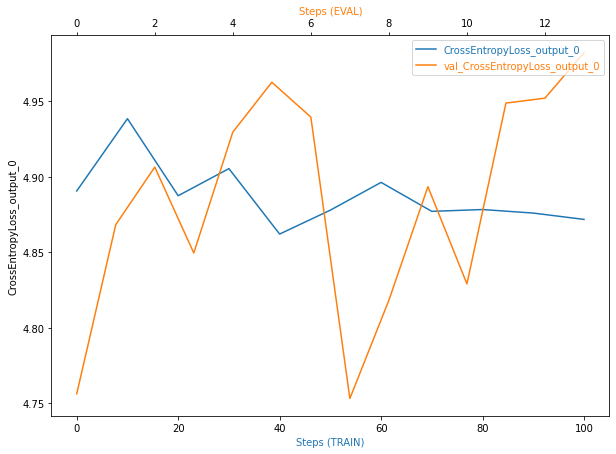

In [47]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [48]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-124974773620/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-19-25-06-873/profiler-output


Profiler data from system is available


In [49]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-03-09 20:13:37.851 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:29 INFO metrics_reader_base.py:134] Getting 42 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


# Display the Profiler Report

In [50]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [51]:
! aws s3 ls {rule_output_path} --recursive

2023-03-09 20:07:24     374926 pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-09 20:07:24     222840 pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-09 20:07:19        192 pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-09 20:07:19        200 pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-09 20:07:19       1939 pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-09 20:07:19        127 pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-09 20:07:19        199 pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-re

In [52]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-19-25-06-873/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-124

In [53]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [54]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-19-25-06-873/rule-output


In [55]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [56]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_report", "zip", "ProfilerReport")

'/root/computer-vision-project-starter/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_report.zip'

## Model Deploying

In [57]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: pytorch-training-2023-03-09-20-16-48-263
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-03-09-20-16-48-263


-------!

In [58]:
print(predictor.endpoint_name)
endpoint_name = predictor.endpoint_name

pytorch-training-2023-03-09-20-16-48-263


In [61]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


model_data_artifacts = "s3://sagemaker-us-east-1-124974773620/pytorch-training-2023-03-09-20-16-48-263/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                             role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor)

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium") #Using ml.t2.medium to save costs

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-09-20-39-01-611
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-09-20-39-02-394


---------!

Test image no: 1
Below is the image that we will be testing:


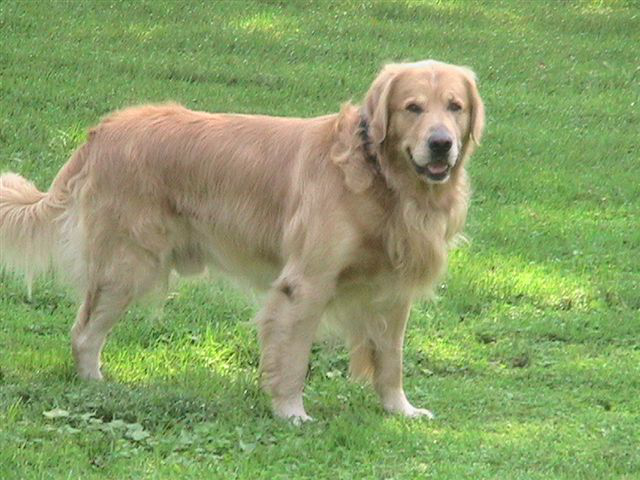

Expected dog breed category no : 76


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2023-03-09-20-39-02-394 in account 124974773620 for more information.

In [64]:
# TODO: Run an prediction on the endpoint
from PIL import Image
import io
import os
import numpy as np
import boto3
import json
import base64
import PIL
# setting the  environment variables

ENDPOINT_NAME = endpoint_name

test_dir = "./dogImages/test/"
test_images = ["076.Golden_retriever/Golden_retriever_05258.jpg", '011.Australian_cattle_dog/Australian_cattle_dog_00788.jpg', "129.Tibetan_mastiff/Tibetan_mastiff_08138.jpg"]
test_images_expected_output = [76, 11, 21]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")
        print("----------------------------------------------------------------------")

In [65]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-09-20-39-02-394
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-09-20-39-02-394
